<a href="https://colab.research.google.com/github/skywalker0803r/AlphaCoin/blob/main/%E7%AC%AC%E4%B8%89%E7%AB%A0(%E5%9B%9E%E6%B8%AC%E5%87%BD%E6%95%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from abc import ABC, abstractmethod
import pandas as pd
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

class BaseStrategy(ABC):
    def __init__(self, data: pd.DataFrame):
        """
        :param data: 包含收盤價等欄位的歷史資料 DataFrame
        """
        self.data = data
        self.signals = pd.Series(index=self.data.index, dtype="object")

    @abstractmethod
    def generate_signals(self):
        """
        子類別實作策略邏輯，填入 self.signals（'buy', 'sell', 'hold'）
        """
        pass

    def get_signals(self) -> pd.Series:
        return self.signals

class MACDStrategy(BaseStrategy):
    def __init__(self, data: pd.DataFrame, fast=12, slow=26, signal=9):
        super().__init__(data)
        self.fast = fast
        self.slow = slow
        self.signal_period = signal

    def generate_signals(self):
        close = self.data['close']
        ema_fast = close.ewm(span=self.fast, adjust=False).mean()
        ema_slow = close.ewm(span=self.slow, adjust=False).mean()
        macd = ema_fast - ema_slow
        signal_line = macd.ewm(span=self.signal_period, adjust=False).mean()

        self.signals = pd.Series(index=self.data.index, dtype="object")
        self.signals[macd > signal_line] = 'buy'
        self.signals[macd < signal_line] = 'sell'
        self.signals[macd == signal_line] = 'hold'

class RSIStrategy(BaseStrategy):
    def __init__(self, data: pd.DataFrame, period=14, overbought=70, oversold=30):
        super().__init__(data)
        self.period = period
        self.overbought = overbought
        self.oversold = oversold

    def generate_signals(self):
        delta = self.data['close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.rolling(self.period).mean()
        avg_loss = loss.rolling(self.period).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        self.signals = pd.Series(index=self.data.index, dtype="object")
        self.signals[rsi < self.oversold] = 'buy'
        self.signals[rsi > self.overbought] = 'sell'
        self.signals[(rsi >= self.oversold) & (rsi <= self.overbought)] = 'hold'


class FurongStrategy(BaseStrategy):
    def __init__(self, data: pd.DataFrame):
        super().__init__(data)
        self.data = data

    def generate_signals(self):
        close = self.data['close']

        ma5 = close.rolling(5).mean()
        ma10 = close.rolling(10).mean()
        ma20 = close.rolling(20).mean()

        # 進場條件
        cond1 = (close > ma5) & (close > ma10) & (close > ma20)
        cond2 = (close.shift(5) < ma5.shift(5)) & (close.shift(5) < ma10.shift(5)) & (close.shift(5) < ma20.shift(5))
        buy_condition = cond1 & cond2

        signals = pd.Series(index=close.index, dtype='object')
        position = False  # 持倉狀態
        entry_price = 0   # 進場價格
        holding_days = 0  # 持倉天數計數器

        for i in range(len(close)):
            price = close.iloc[i]

            if not position:
                # 尚未持倉，判斷是否進場
                if buy_condition.iloc[i]:
                    signals.iloc[i] = 'buy'
                    position = True
                    entry_price = price
                    holding_days = 1  # 第一天持倉
                else:
                    signals.iloc[i] = 'hold'
            else:
                # 持倉中，判斷是否停利/停損或超過7天出場
                change_pct = (price - entry_price) / entry_price

                holding_days += 1  # 持續計算持倉天數

                if change_pct >= 0.07:
                    signals.iloc[i] = 'sell'  # 漲7%出場
                    position = False
                    entry_price = 0
                    holding_days = 0
                elif change_pct <= -0.03:
                    signals.iloc[i] = 'sell'  # 跌3%出場
                    position = False
                    entry_price = 0
                    holding_days = 0
                elif holding_days > 7:
                    signals.iloc[i] = 'sell'  # 超過7天強制出場
                    position = False
                    entry_price = 0
                    holding_days = 0
                else:
                    signals.iloc[i] = 'hold'

        self.signals = signals


import yfinance as yf
import datetime
import pandas as pd

# 下載多幣種也沒問題
df = yf.download("BTC-USD", start="2025-01-01", end=datetime.datetime.now())

# 通用欄位標準化
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join([str(c).lower() for c in col]) for col in df.columns]
    tickers = set(col.split('_')[-1] for col in df.columns)
    if len(tickers) == 1:
        ticker_suffix = list(tickers)[0]
        df.columns = [col.replace(f"_{ticker_suffix}", '') for col in df.columns]
else:
    df.columns = df.columns.str.lower()

# 檢查是否有 close
assert 'close' in df.columns, "找不到 close 欄位"

# 套用策略
strategy = MACDStrategy(df)
strategy.generate_signals()
strategy.get_signals()

--2025-06-26 13:14:33--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 209.85.200.139, 209.85.200.138, 209.85.200.102, ...
Connecting to drive.google.com (drive.google.com)|209.85.200.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-06-26 13:14:33--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.179.132, 2607:f8b0:4001:c68::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.179.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M   120MB/s    in 0.2s    

2025-06-26 13:14:

[*********************100%***********************]  1 of 1 completed


,0
Date,
2025-01-01,hold
2025-01-02,buy
2025-01-03,buy
2025-01-04,buy
2025-01-05,buy
...,...
2025-06-22,sell
2025-06-23,sell
2025-06-24,sell


# 回測函數

In [46]:
import pandas as pd
import numpy as np

def backtest_strategy(strategy: BaseStrategy,
                      data: pd.DataFrame,
                      initial_cash: float,
                      start_date: str,
                      end_date: str,
                      fee_rate: float = 0.001,
                      risk_free_rate: float = 0.0) -> dict:
    strategy.generate_signals()
    signals = strategy.get_signals().copy()
    data = data.loc[start_date:end_date].copy()
    signals = signals.loc[start_date:end_date]

    position = 0
    cash = initial_cash
    asset_curve = []
    trade_log = []
    entry_price = 0

    for date, signal in signals.items():
        price = data.loc[date, 'close']

        if signal == 'buy' and position == 0:
            position = cash * (1 - fee_rate) / price
            entry_price = price
            cash = 0
            trade_log.append({
                'entry_date': date,
                'entry_price': price,
                'exit_date': None,
                'exit_price': None,
                'return': None,
                'holding_days': None
            })

        elif signal == 'sell' and position > 0:
            exit_price = price
            cash = position * exit_price * (1 - fee_rate)
            ret = (exit_price - entry_price) / entry_price
            holding_days = (date - trade_log[-1]['entry_date']).days

            trade_log[-1].update({
                'exit_date': date,
                'exit_price': exit_price,
                'return': ret,
                'holding_days': holding_days
            })

            position = 0
            entry_price = 0

        total_value = cash + position * price
        asset_curve.append((date, total_value))

    if position > 0:
        price = data.iloc[-1]['close']
        cash = position * price * (1 - fee_rate)
        ret = (price - entry_price) / entry_price
        holding_days = (data.index[-1] - trade_log[-1]['entry_date']).days
        trade_log[-1].update({
            'exit_date': data.index[-1],
            'exit_price': price,
            'return': ret,
            'holding_days': holding_days
        })
        asset_curve.append((data.index[-1], cash))
        position = 0

    asset_df = pd.DataFrame(asset_curve, columns=['date', 'total_asset']).set_index('date')
    returns = asset_df['total_asset'].pct_change().dropna()

    trades_df = pd.DataFrame(trade_log).dropna()
    num_trades = len(trades_df)
    win_rate = (trades_df['return'] > 0).sum() / num_trades if num_trades > 0 else 0
    avg_profit = trades_df[trades_df['return'] > 0]['return'].mean()
    avg_loss = trades_df[trades_df['return'] < 0]['return'].mean()
    profit_loss_ratio = avg_profit / abs(avg_loss) if avg_loss != 0 and not np.isnan(avg_loss) else np.nan
    pl_ratio_total = trades_df[trades_df['return'] > 0]['return'].sum() / abs(trades_df[trades_df['return'] < 0]['return'].sum()) if any(trades_df['return'] < 0) else np.nan
    expectancy = win_rate * avg_profit + (1 - win_rate) * avg_loss if not np.isnan(avg_profit) and not np.isnan(avg_loss) else np.nan
    avg_holding_days = trades_df['holding_days'].mean() if 'holding_days' in trades_df else np.nan

    final_asset = asset_df['total_asset'].iloc[-1]
    total_return = (final_asset - initial_cash) / initial_cash
    duration_years = (asset_df.index[-1] - asset_df.index[0]).days / 365.25
    cagr = (final_asset / initial_cash) ** (1 / duration_years) - 1 if duration_years > 0 else np.nan
    sharpe_ratio = (returns.mean() - risk_free_rate / 252) / returns.std() * np.sqrt(252) if returns.std() > 0 else np.nan
    running_max = asset_df['total_asset'].cummax()
    drawdown = asset_df['total_asset'] / running_max - 1
    max_drawdown = drawdown.min()

    return {
        'asset_curve': asset_df,
        'final_asset': final_asset,
        'total_return': total_return,
        'cagr': cagr,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'profit_loss_ratio_avg': profit_loss_ratio,
        'profit_loss_ratio_total': pl_ratio_total,
        'expectancy': expectancy,
        'avg_holding_days': avg_holding_days,
        'num_trades': num_trades,
        'avg_profit': avg_profit,
        'avg_loss': avg_loss,
        'trades': trades_df
    }


總報酬率: -5.66%
年化報酬率: -13.16%
夏普比率: -0.22
最大回撤: -25.33%
勝率: 25.00%
平均盈虧比: 2.88
總盈虧比: 0.96
期望值: -0.0013
平均持倉日: 11.00
總交易次數: 8


,entry_date,entry_price,exit_date,exit_price,return,holding_days
0,2025-01-02,96886.875000,2025-01-09,92484.039062,-0.045443,7
1,2025-01-15,100504.492188,2025-01-28,101332.476562,0.008238,13
2,2025-02-20,98333.937500,2025-02-24,91418.171875,-0.070329,4
3,2025-03-06,89961.726562,2025-03-08,86154.593750,-0.042319,2
4,2025-03-15,84343.109375,2025-04-06,78214.484375,-0.072663,22
5,2025-04-11,83404.835938,2025-05-17,103191.085938,0.237231,36
6,2025-05-18,106446.007812,2025-05-19,105606.179688,-0.007890,1
7,2025-05-21,109678.078125,2025-05-24,107791.156250,-0.017204,3


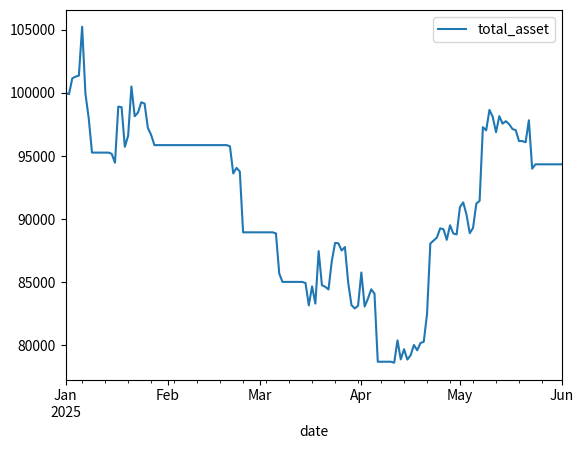

In [47]:
import warnings
warnings.filterwarnings("ignore")

result = backtest_strategy(strategy=MACDStrategy(df), data=df,
                           initial_cash=100000,
                           start_date="2024-01-01",
                           end_date="2025-06-01")

print(f"總報酬率: {result['total_return']:.2%}")
print(f"年化報酬率: {result['cagr']:.2%}")
print(f"夏普比率: {result['sharpe_ratio']:.2f}")
print(f"最大回撤: {result['max_drawdown']:.2%}")
print(f"勝率: {result['win_rate']:.2%}")
print(f"平均盈虧比: {result['profit_loss_ratio_avg']:.2f}")
print(f"總盈虧比: {result['profit_loss_ratio_total']:.2f}")
print(f"期望值: {result['expectancy']:.4f}")
print(f"平均持倉日: {result['avg_holding_days']:.2f}")
print(f"總交易次數: {result['num_trades']}")
result['asset_curve'].plot()
result['trades']

總報酬率: -2.63%
年化報酬率: -6.24%
夏普比率: 0.04
最大回撤: -22.44%
勝率: 0.00%
平均盈虧比: nan
總盈虧比: 0.00
期望值: nan
平均持倉日: 64.00
總交易次數: 1


,entry_date,entry_price,exit_date,exit_price,return,holding_days
0,2025-02-17,95773.382812,2025-04-22,93441.890625,-0.024344,64


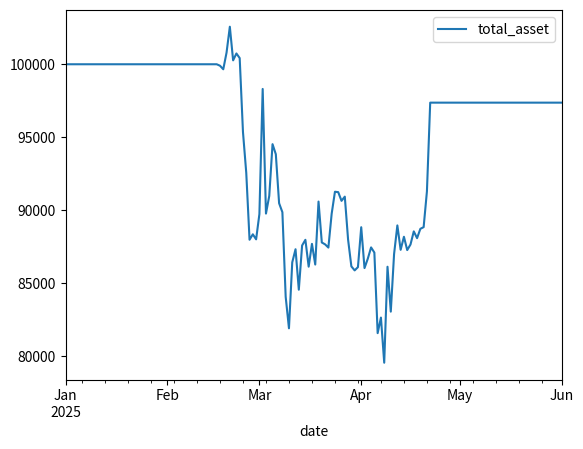

In [48]:
import warnings
warnings.filterwarnings("ignore")

result = backtest_strategy(strategy=RSIStrategy(df), data=df,
                           initial_cash=100000,
                           start_date="2024-01-01",
                           end_date="2025-06-01")

print(f"總報酬率: {result['total_return']:.2%}")
print(f"年化報酬率: {result['cagr']:.2%}")
print(f"夏普比率: {result['sharpe_ratio']:.2f}")
print(f"最大回撤: {result['max_drawdown']:.2%}")
print(f"勝率: {result['win_rate']:.2%}")
print(f"平均盈虧比: {result['profit_loss_ratio_avg']:.2f}")
print(f"總盈虧比: {result['profit_loss_ratio_total']:.2f}")
print(f"期望值: {result['expectancy']:.4f}")
print(f"平均持倉日: {result['avg_holding_days']:.2f}")
print(f"總交易次數: {result['num_trades']}")
result['asset_curve'].plot()
result['trades']

總報酬率: -7.91%
年化報酬率: -18.06%
夏普比率: -1.06
最大回撤: -8.96%
勝率: 50.00%
平均盈虧比: 0.14
總盈虧比: 0.14
期望值: -0.0371
平均持倉日: 4.00
總交易次數: 2


,entry_date,entry_price,exit_date,exit_price,return,holding_days
0,2025-03-02,94248.351562,2025-03-03,86065.671875,-0.086820,1
1,2025-04-11,83404.835938,2025-04-18,84450.804688,0.012541,7


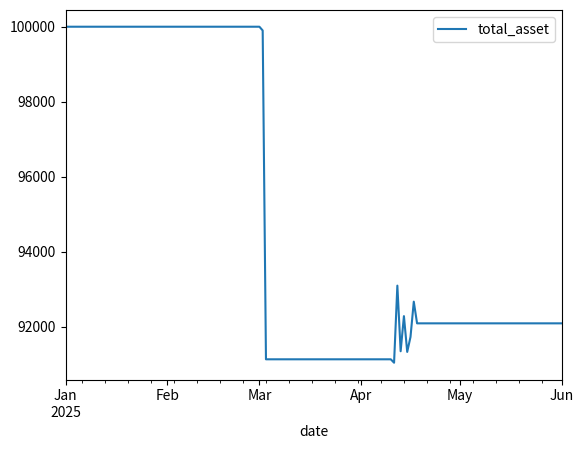

In [49]:
import warnings
warnings.filterwarnings("ignore")

result = backtest_strategy(strategy=FurongStrategy(df), data=df,
                           initial_cash=100000,
                           start_date="2024-01-01",
                           end_date="2025-06-01")

print(f"總報酬率: {result['total_return']:.2%}")
print(f"年化報酬率: {result['cagr']:.2%}")
print(f"夏普比率: {result['sharpe_ratio']:.2f}")
print(f"最大回撤: {result['max_drawdown']:.2%}")
print(f"勝率: {result['win_rate']:.2%}")
print(f"平均盈虧比: {result['profit_loss_ratio_avg']:.2f}")
print(f"總盈虧比: {result['profit_loss_ratio_total']:.2f}")
print(f"期望值: {result['expectancy']:.4f}")
print(f"平均持倉日: {result['avg_holding_days']:.2f}")
print(f"總交易次數: {result['num_trades']}")
result['asset_curve'].plot()
result['trades']